<a href="https://colab.research.google.com/github/WPHdamian/Data-Science-Curriculum-Analysis-/blob/main/05_EDISON_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 5 - Mapping ESCO Skills to EDISON Competence Domains

## Objective
This notebook translates extracted ESCO-aligned skills into higher-level
EDISON competence domains to enable pedagogical interpretation of
curriculum emphasis.



## Setup

## EDISON Domains

- DSDA: Data Analytics  
- DSENG: Data Engineering  
- DSDM: Data Management  
- DSTF: Theoretical Fundamentals  
- DSAD: Application Development  
- DSBA: Domain Competences  
- DSPC: Personal Competencies


In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [76]:
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

output_dir = Path("Output")
output_dir.mkdir(exist_ok=True)


In [37]:
df = pd.read_parquet("curriculum_with_esco.parquet")
esco = pd.read_csv("skills_en.csv")
edison = pd.read_csv("edison_mapping.csv")


## Prepare ESCO Labels

In [38]:
def normalize(text):
    return (
        text.lower()
        .replace("-", " ")
        .replace("_", " ")
        .strip()
    )

In [39]:
esco["preferred_norm"] = esco["preferredLabel"].apply(normalize)

esco["alt_norm"] = (
    esco["altLabels"]
    .fillna("")
    .apply(lambda x: [normalize(t) for t in x.split("\n") if t.strip() != ""])
)


In [40]:
# explode ESCO into surface forms
esco_forms = []

for _, row in esco.iterrows():
    esco_forms.append({
        "conceptUri": row["conceptUri"],
        "skillType": row["skillType"],
        "surface": row["preferred_norm"]
    })
    for alt in row["alt_norm"]:
        esco_forms.append({
            "conceptUri": row["conceptUri"],
            "skillType": row["skillType"],
            "surface": alt
        })

esco_forms = pd.DataFrame(esco_forms)
esco_forms.head()

,conceptUri,skillType,surface
0,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,manage musical staff
1,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,manage music staff
2,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,coordinate duties of musical staff
3,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,direct musical staff
4,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,manage staff of music


## Preparing EDISON Skill Labels

EDISON skill labels represent abstract pedagogical competencies rather than operational skills.
They must therefore be matched approximately rather than exactly.


In [45]:
edison["skill_norm"] = edison["skill_label"].apply(normalize)
edison.head()


,EDISON_domain,competency_id,skill_type,skill_label,skill_norm
0,DSDA,DSDA01_AnalyticalTechniques,knowledge,text_mining,text mining
1,DSDA,DSDA01_AnalyticalTechniques,knowledge,descriptive_analytics,descriptive analytics
2,DSDA,DSDA01_AnalyticalTechniques,knowledge,quantitative_analytics,quantitative analytics
3,DSDA,DSDA01_AnalyticalTechniques,knowledge,qualitative_analytics,qualitative analytics
4,DSDA,DSDA01_AnalyticalTechniques,knowledge,predictive_analytics,predictive analytics


## Similarity Function

In [46]:
def jaccard(a, b):
    A = set(a.split())
    B = set(b.split())
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)

## ESCO to EDISON Matching (With Threshold)

ESCO skills are mapped to EDISON domains if their lexical overlap exceeds
a minimum similarity threshold. This prevents spurious matches while allowing
conceptual alignment.


In [47]:
MATCH_THRESHOLD = 0.5

matches = []

for _, esco_row in esco_forms.iterrows():
    for _, ed_row in edison.iterrows():
        score = jaccard(esco_row["surface"], ed_row["skill_norm"])
        if score >= MATCH_THRESHOLD:
            matches.append({
                "conceptUri": esco_row["conceptUri"],
                "esco_surface": esco_row["surface"],
                "EDISON_domain": ed_row["EDISON_domain"],
                "competency_id": ed_row["competency_id"],
                "edison_skill": ed_row["skill_label"],
                "similarity": score
            })

esco_edison_map = pd.DataFrame(matches)
esco_edison_map.sort_values("similarity", ascending=False).head(20)


,conceptUri,esco_surface,EDISON_domain,competency_id,edison_skill,similarity
1865,http://data.europa.eu/esco/skill/f9a6f35b-01a7...,operating systems,DSENG,DSENG04_AnalysisApplicationsAndInfrastructures,operating_systems,1.0
1876,http://data.europa.eu/esco/skill/fbafa41f-cd05...,create data models,DSDM,DSDM02_DataModels,create_data_models,1.0
1867,http://data.europa.eu/esco/skill/f9a6f35b-01a7...,operating systems,DSTF,DSTF03_ComputerScienceBasics,operating_systems,1.0
1761,http://data.europa.eu/esco/skill/de03f4fd-c147...,customer relationship management,DSBA,DSBA01_InformationNeeds,customer_relationship_management,1.0
1798,http://data.europa.eu/esco/skill/ecc4552a-92c5...,deep learning,DSDA,DSDA05_MachineLearning,deep_learning,1.0
1747,http://data.europa.eu/esco/skill/dc9a236c-c640...,customer relationship management,DSBA,DSBA06_DataDrivenMarketing,customer_relationship_management,1.0
1746,http://data.europa.eu/esco/skill/dc9a236c-c640...,customer relationship management,DSBA,DSBA05_CustomerRelationshipManagement,customer_relationship_management,1.0
1745,http://data.europa.eu/esco/skill/dc9a236c-c640...,customer relationship management,DSBA,DSBA01_InformationNeeds,customer_relationship_management,1.0
1763,http://data.europa.eu/esco/skill/de03f4fd-c147...,customer relationship management,DSBA,DSBA06_DataDrivenMarketing,customer_relationship_management,1.0
1762,http://data.europa.eu/esco/skill/de03f4fd-c147...,customer relationship management,DSBA,DSBA05_CustomerRelationshipManagement,customer_relationship_management,1.0


## Deduplicate

To avoid over-counting, each ESCO concept is assigned to its highest-similarity
EDISON competence.


In [48]:
esco_edison_final = (
    esco_edison_map
    .sort_values("similarity", ascending=False)
    .groupby("conceptUri")
    .first()
    .reset_index()
)


In [49]:
coverage = esco_edison_final["EDISON_domain"].notna().mean()
coverage


np.float64(1.0)

In [66]:
esco_edison_final.to_csv(
    "esco_to_edison_semantic.csv",
    index=False
)

100% cover rate

## 5.1 Purpose

Now that every ESCO skill has a corresponding EDISON domain and competency ID, we can map each module’s extracted ESCO skills to higher-order pedagogical categories. This enables interpretation of curriculum emphasis at the **domain** and **competency** level, which directly supports RQ1.


In [68]:
def normalize(token):
    return token.lower().replace("-", "_").replace(" ", "_")
esco_edison_map["esco_surface_norm"] = esco_edison_map["esco_surface"].apply(normalize)
df["clean_tokens_norm"] = df["clean_tokens_expanded"].apply(lambda x: [normalize(t) for t in x])


In [69]:
# Lookup: normalized ESCO surface → EDISON info
lookup = {}
for _, row in esco_edison_map.iterrows():
    surface = row["esco_surface_norm"]
    lookup[surface] = {
        "EDISON_domain": row["EDISON_domain"],
        "competency_id": row["competency_id"],
        "edison_skill": row["edison_skill"]
    }


In [70]:
model = SentenceTransformer("all-MiniLM-L6-v2")

esco_surfaces = list(lookup.keys())
esco_embeddings = model.encode(esco_surfaces, convert_to_tensor=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [71]:
# Normalize curriculum tokens
df["clean_tokens_norm"] = df["clean_tokens_expanded"].apply(lambda x: [normalize(t) for t in x])

def map_tokens_semantic(tokens, lookup, embeddings, surface_list, model, threshold=0.7):
    matched_domains = set()
    matched_competencies = set()
    matched_skills = set()

    if not tokens:
        return [], [], []

    token_embeddings = model.encode(tokens, convert_to_tensor=True)
    sims = cosine_similarity(token_embeddings, embeddings)

    for i, tok in enumerate(tokens):
        j = np.argmax(sims[i])
        if sims[i, j] >= threshold:
            surface = surface_list[j]
            info = lookup[surface]
            matched_domains.add(info["EDISON_domain"])
            matched_competencies.add(info["competency_id"])
            matched_skills.add(info["edison_skill"])
    return list(matched_domains), list(matched_competencies), list(matched_skills)


In [72]:
df["edison_domains"], df["edison_competencies"], df["edison_skills_mapped"] = zip(
    *df["clean_tokens_norm"].apply(
        lambda x: map_tokens_semantic(
            x, lookup, esco_embeddings, esco_surfaces, model, threshold=0.7
        )
    )
)

df["edison_domain_count"] = df["edison_domains"].apply(len)


In [73]:
coverage = (df["edison_domain_count"] > 0).mean()
print(f"Modules with at least one EDISON domain: {coverage:.2%}")

# Inspect first few modules
df[["module_code","clean_tokens_expanded","edison_domains","edison_competencies","edison_skills_mapped"]].head()


Modules with at least one EDISON domain: 71.02%


,module_code,clean_tokens_expanded,edison_domains,edison_competencies,edison_skills_mapped
0,AC4301,"[financial, accounting_standard, information, ...","[DSPC, DSBA]","[DSBA07_BusinessAndOrganization, DSPC05_Teamwork]","[business_process_management, effective_commun..."
1,AC4342,"[identify, communication, written, ability, co...","[DSPC, DSDA]","[DSDA05_MachineLearning, DSPC07_EthicalThinkin...","[ethics, effective_communication, use_sampling..."
2,CB2100,"[financial, information, general, processing, ...",[],[],[]
3,CB2101,"[identify, foundation, valuation, product, man...",[],[],[]
4,CB2200,"[management_decision_making, business, ability...",[DSDA],[DSDA02_QuantitativeTechniques],[statistical_analysis_software]


In [74]:
df_exploded = df.explode("edison_domains")

domain_counts = (
    df_exploded.groupby(["city", "edison_domains"])
              .size()
              .reset_index(name="count")
)

domain_counts["proportion"] = domain_counts.groupby("city")["count"].transform(lambda x: x / x.sum())


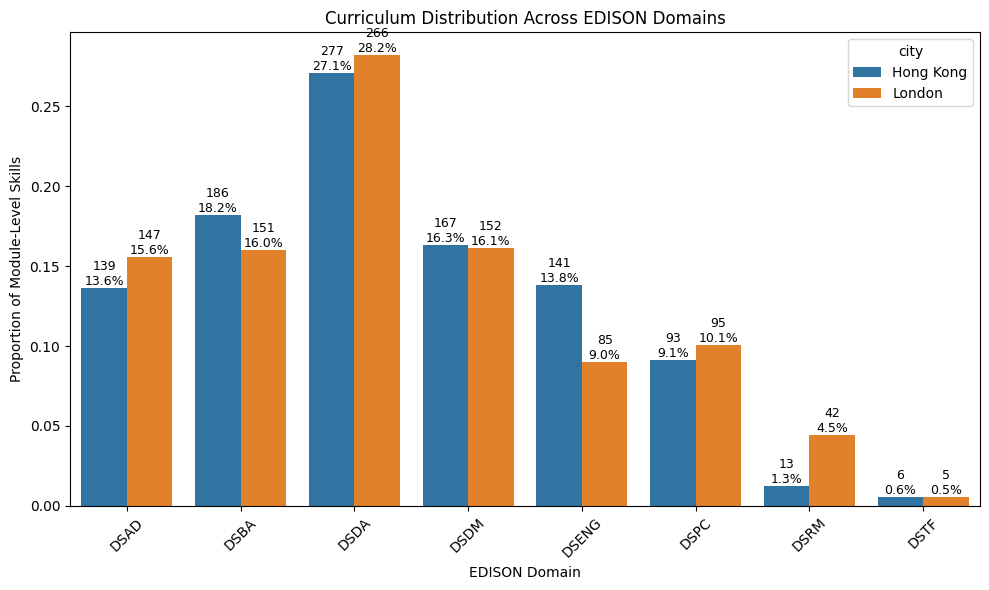

In [78]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="edison_domains", y="proportion", hue="city", data=domain_counts)

# Rotate x labels
plt.xticks(rotation=45)
plt.ylabel("Proportion of Module-Level Skills")
plt.xlabel("EDISON Domain")
plt.title("Curriculum Distribution Across EDISON Domains")

# Annotate each bar with count and percentage
for i, row in domain_counts.iterrows():
    # Find bar coordinates
    x_coord = row.name  # we will adjust below
    city_idx = 0 if row['city']=='Hong Kong' else 1  # hue order
    # Use ax.patches in order: bars for each domain grouped by hue
    patch = ax.patches[i]
    height = patch.get_height()
    count = row['count']
    ax.annotate(f"{count}\n{height:.1%}",
                (patch.get_x() + patch.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.savefig(output_dir / "edison_domain_distribution_counts.png")
plt.show()


In [65]:
df.to_parquet("curriculum_with_edison.parquet", index=False)
